In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
data = os.path.join(r'D:\Garbage classification')
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
for label in labels:
    directory = os.path.join(data, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Images of label "cardboard":	 403
Images of label "glass":	 501
Images of label "metal":	 410
Images of label "paper":	 594
Images of label "plastic":	 482
Images of label "trash":	 137


*Pre-processing images and copying them to their respective directory*

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

def dataset_split(data_dir, output_dir, test_size=0.2, val_size=0.2):
    #create directories for the train, validation, and test sets
    splits = ['train', 'val', 'test']
    class_names = os.listdir(data_dir)

    for split in splits:
        for class_name in class_names:
            class_dir_out = os.path.join(output_dir, split, class_name)
            os.makedirs(class_dir_out, exist_ok=True)

    #process each class directory
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        #conditions for images check
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
        train_val, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val, test_size=val_size / (1 - test_size), random_state=42)

        #function to copy images to the respective directories
        def copy_images(image_list, output_dir):
            for image in image_list:
                dest = os.path.join(output_dir, os.path.basename(image))
                shutil.copy(image, dest)

        #Copy images to their respective directories for each set
        copy_images(train_images, os.path.join(output_dir, 'train', class_name))
        copy_images(val_images, os.path.join(output_dir, 'val', class_name))
        copy_images(test_images, os.path.join(output_dir, 'test', class_name))

#Set the paths
source_directory = r'D:\Garbage classification'
target_directory = r'D:\Split_Garbage_classification'

#Calling function
dataset_split(source_directory, target_directory)


*Scaling the data and transforming to our desired shape*

In [ ]:
#Setting up parameters
IMAGE_SIZE = 256
batch_size = 32

#ImageDataGenerator for training data
data_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

#training data
train_batch = data_generator.flow_from_directory(
    r'D:\Split_Garbage_classification\train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

#validation data
validation_batch = data_generator.flow_from_directory(
    r'D:\Split_Garbage_classification\val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

#test data
test_batch = data_generator.flow_from_directory(
    r'D:\Split_Garbage_classification\test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1211 images belonging to 6 classes.
Found 99 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


*Building model*

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers



def make_model(class_num = 6):

  model = models.Sequential()

  ## Convolutional base
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))),
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu')),
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu')),
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  #model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  #model.add(layers.MaxPooling2D((2, 2)))

  ## Dense head
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))  # for multi-class classification
  model.add(layers.Dropout(0.5))  #dropout with a dropout rate of 0.5
  model.add(layers.Dense(class_num, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate= 0.0001),
              metrics=['acc'])

  return model

model = make_model(class_num = 6)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                     

In [ ]:
# Train the model
history = model.fit(
    train_batch,
    steps_per_epoch=train_batch.samples // batch_size,
    validation_data=validation_batch,
    validation_steps=validation_batch.samples // batch_size,
    epochs=20
)

#model_path = '/content/drive/MyDrive/Colab_Notebooks/DL/model_NO_augmentation.keras'

# Save the model
model.save("model_NO_augmentation")

Epoch 1/20
37/37 [==============================] - 63s 2s/step - loss: 6.4204 - acc: 0.4843 - val_loss: 3.2829 - val_acc: 0.0521
Epoch 2/20
37/37 [==============================] - 62s 2s/step - loss: 1.6341 - acc: 0.7235 - val_loss: 3.0997 - val_acc: 0.2083
Epoch 3/20
37/37 [==============================] - 62s 2s/step - loss: 0.9094 - acc: 0.7990 - val_loss: 3.4599 - val_acc: 0.1979
Epoch 4/20
37/37 [==============================] - 61s 2s/step - loss: 0.6781 - acc: 0.8550 - val_loss: 3.8962 - val_acc: 0.2604
Epoch 5/20
37/37 [==============================] - 62s 2s/step - loss: 0.5438 - acc: 0.9042 - val_loss: 7.4909 - val_acc: 0.1979
Epoch 6/20
37/37 [==============================] - 62s 2s/step - loss: 0.3518 - acc: 0.9228 - val_loss: 6.6689 - val_acc: 0.2292
Epoch 7/20
37/37 [==============================] - 62s 2s/step - loss: 0.3103 - acc: 0.9338 - val_loss: 7.8822 - val_acc: 0.2083
Epoch 8/20
37/37 [==============================] - 62s 2s/step - loss: 0.3835 - acc: 0.93

INFO:tensorflow:Assets written to: model_NO_augmentation\assets


In [ ]:
#Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(test_batch)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

16/16 [==============================] - 4s 243ms/step - loss: 3.1273 - acc: 0.6240
Test Accuracy: 62.40%


In [ ]:
#Setting up parameters
IMAGE_SIZE = 256
batch_size = 32

# Define data augmentation parameters
data_generator_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

#train set
train_batch_aug = data_generator_aug.flow_from_directory(
    r'D:\Split_Garbage_classification\train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

#validation set
validation_batch_aug = data_generator_aug.flow_from_directory(
    r'D:\Split_Garbage_classification\val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1211 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [ ]:
model = make_model()

#enabling TensorFlow Profiler
tf.profiler.experimental.start('logs')

#define TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

#training with tensor board callback
history_aug = model.fit(
    train_batch_aug,
    steps_per_epoch=train_batch_aug.samples // batch_size,
    validation_data=validation_batch_aug,
    validation_steps=validation_batch_aug.samples // batch_size,
    epochs=20,
    callbacks=[tensorboard_callback]
)

#stop profiling
tf.profiler.experimental.stop()

Epoch 1/20
37/37 [==============================] - 63s 2s/step - loss: 7.2398 - acc: 0.4682 - val_loss: 2.0301 - val_acc: 0.2188
Epoch 2/20
37/37 [==============================] - 63s 2s/step - loss: 3.2492 - acc: 0.5598 - val_loss: 4.2744 - val_acc: 0.1979
Epoch 3/20
37/37 [==============================] - 61s 2s/step - loss: 2.4616 - acc: 0.5776 - val_loss: 5.0620 - val_acc: 0.2188
Epoch 4/20
37/37 [==============================] - 62s 2s/step - loss: 1.7926 - acc: 0.6293 - val_loss: 3.8752 - val_acc: 0.2812
Epoch 5/20
37/37 [==============================] - 62s 2s/step - loss: 1.6189 - acc: 0.6429 - val_loss: 5.6679 - val_acc: 0.2083
Epoch 6/20
37/37 [==============================] - 61s 2s/step - loss: 1.5738 - acc: 0.6472 - val_loss: 4.0901 - val_acc: 0.2188
Epoch 7/20
37/37 [==============================] - 62s 2s/step - loss: 1.2903 - acc: 0.6904 - val_loss: 3.6245 - val_acc: 0.2604
Epoch 8/20
37/37 [==============================] - 61s 2s/step - loss: 1.2893 - acc: 0.68

In [ ]:
#Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_batch)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

16/16 [==============================] - 4s 249ms/step - loss: 1.5205 - acc: 0.6929
Test Accuracy: 69.29%


In [ ]:
#model_path = '/content/drive/MyDrive/Colab_Notebooks/DL/model_YES_augmentation.keras'
model.save("model_YES_augmentation")

INFO:tensorflow:Assets written to: model_YES_augmentation\assets


INFO:tensorflow:Assets written to: model_YES_augmentation\assets


In [ ]:
%load_ext tensorboard

%tensorboard --logdir=logs

16/16 [==============================] - 6s 376ms/step


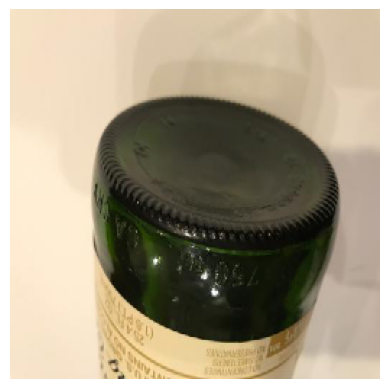

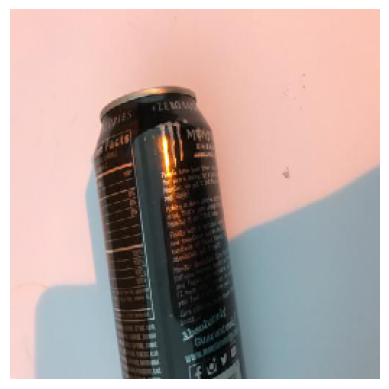

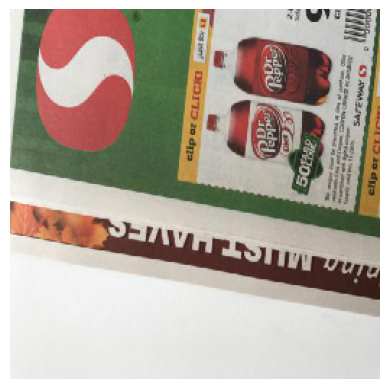

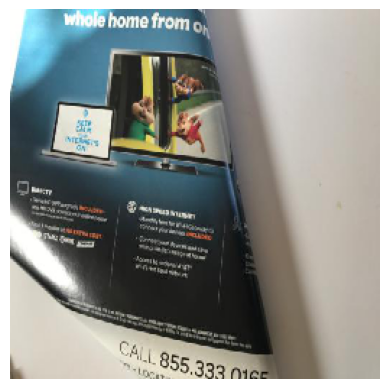

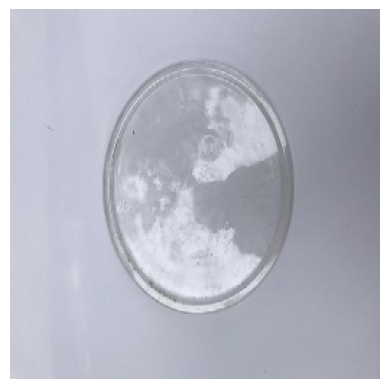

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained model
# model_filename = 'model_YES_augmentation.keras'  # Only the filename, not the full path
# model_path = '/content/drive/MyDrive/Colab_Notebooks/DL/' + model_filename  # Full path including the folder

model = load_model("model_YES_augmentation")

#Predict labels for the test dataset
predictions = model.predict(test_batch)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test generator
true_labels = test_batch.classes

# Find misclassified images
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Get a few misclassified images for analysis
num_images_to_show = 5
for i in range(num_images_to_show):
    # Get the index of a misclassified image
    misclassified_index = misclassified_indices[i]

    # Get the corresponding image and label from the test generator
    misclassified_image, misclassified_label = test_batch[misclassified_index]

    # Visualize the misclassified image
    plt.imshow(misclassified_image[0])
    plt.axis('off')
    plt.show()

### Improve model generalisability across domains

Visualizing sample images from the original test dataset:


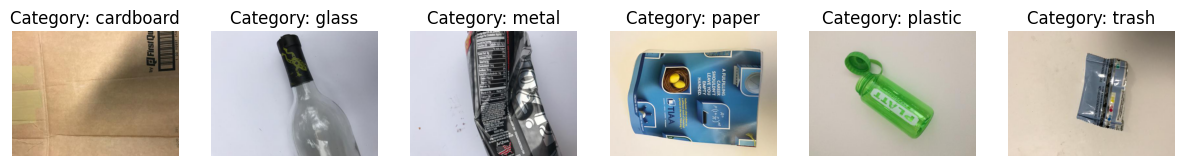

Visualizing sample images from the newly added test dataset:


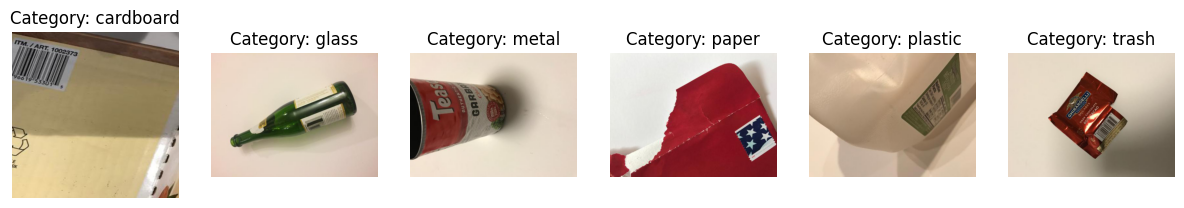

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_class_images(directory_path):
    # Set up a plot with 1 row and 6 columns
    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    # Alphabetically sort class names found in the directory
    categories = sorted(os.listdir(directory_path))

    # Loop through each category and corresponding axis
    for ax, category in zip(axes, categories):
        category_folder = os.path.join(directory_path, category)
        images = os.listdir(category_folder)
        selected_image = random.choice(images)
        image_path = os.path.join(category_folder, selected_image)
        img = Image.open(image_path)

        # Display the image and set titles
        ax.imshow(img)
        ax.set_axis_off()
        ax.set_title(f"Category: {category}")

    # Display all images
    plt.show()

original_test_data_dir = r'D:\Split_Garbage_classification\test'
new_test_data_dir = r'D:\Split_Garbage_classification\new_test_data'

#calling function:
print("Visualizing sample images from the original test dataset:")
display_class_images(original_test_data_dir)

print("Visualizing sample images from the newly added test dataset:")
display_class_images(new_test_data_dir)


**Improving the model so that it generalises better on unseen test images.**

In [ ]:
# Define data augmentation parameters
data_generator_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

#train set
train_batch_aug = data_generator_aug.flow_from_directory(
    r'D:\Split_Garbage_classification\train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

#validation set
validation_batch_aug = data_generator_aug.flow_from_directory(
    r'D:\Split_Garbage_classification\val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1211 images belonging to 6 classes.
Found 99 images belonging to 6 classes.


In [ ]:
# Build and compile your model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # Change the number of units to 6
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#building and compiling model
#model = make_model()

history = model.fit(
    train_batch_aug,
    steps_per_epoch=train_batch_aug.samples // batch_size,
    validation_data=validation_batch_aug,
    validation_steps=validation_batch_aug.samples // batch_size,
    epochs=25
)

Epoch 1/25
37/37 [==============================] - 38s 1s/step - loss: 1.5457 - accuracy: 0.3367 - val_loss: 1.5541 - val_accuracy: 0.3750
Epoch 2/25
37/37 [==============================] - 37s 991ms/step - loss: 1.3671 - accuracy: 0.4419 - val_loss: 1.4921 - val_accuracy: 0.3958
Epoch 3/25
37/37 [==============================] - 37s 989ms/step - loss: 1.3258 - accuracy: 0.4597 - val_loss: 1.5561 - val_accuracy: 0.4062
Epoch 4/25
37/37 [==============================] - 37s 991ms/step - loss: 1.2049 - accuracy: 0.5123 - val_loss: 1.3642 - val_accuracy: 0.4271
Epoch 5/25
37/37 [==============================] - 37s 983ms/step - loss: 1.1829 - accuracy: 0.5293 - val_loss: 1.4120 - val_accuracy: 0.4271
Epoch 6/25
37/37 [==============================] - 37s 987ms/step - loss: 1.0798 - accuracy: 0.5844 - val_loss: 1.4789 - val_accuracy: 0.4167
Epoch 7/25
37/37 [==============================] - 37s 993ms/step - loss: 0.9876 - accuracy: 0.6183 - val_loss: 1.4131 - val_accuracy: 0.3854
Ep

In [ ]:
#Create unseen data
unseen_test_batch = data_generator_aug.flow_from_directory(
    r'D:\Split_Garbage_classification\unseen',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 17 images belonging to 6 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(unseen_test_batch)
print(f"Accuracy from unseen data from a different source: {test_accuracy*100:.2f}%")

1/1 [==============================] - 0s 250ms/step - loss: 0.4535 - accuracy: 0.8824
Accuracy from unseen data from a different source: 88.24%
